# Manager Survey Analysis

**Objectives**:
<br> 1. Discover the areas where managers are excel at -- What does your manager excel at with regard to supporting your development?
<br> 2. Discover the areas of improvement - "What would you tell your manager to do differently so that you are more likely to recommend them as a manager?"
<br> 3. NPS comments on managers - why employee rated manager with a detracter score, passive score, or promoter score

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import nltk
import string
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import TweetTokenizer
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from nltk.util import ngrams

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rouzi.bai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rouzi.bai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [237]:
os.chdir("G:\HRIS\Bai\Manager Effectiveness Survey")

In [238]:
print("Current Working Directory " , os.getcwd())

Current Working Directory  G:\HRIS\Bai\Manager Effectiveness Survey


In [535]:
# import data files

survey = pd.read_csv('Final831.csv')
eelist = pd.read_csv('survey respondents info.csv')

In [536]:
# merge survey info with respondents info based on employee ID

survey = survey.merge(eelist, left_on = 'Employee ID', right_on = 'Employee ID', how = 'left')

# check the dimension of the data
survey.shape

(6792, 31)

In [605]:
#check the number of missing values in each column
survey.isnull().sum()

My manager and I have meaningful discussions about my career aspirations.                                                       0
My manager helps me identify and prioritize my development needs for current and future roles.                                  0
My manager takes actions to support my development.                                                                             0
My manager and I discuss progress on my development goals throughout the year.                                                  0
I believe my manager’s actions have helped prepare me for future opportunities and challenges.                                  0
What does your manager excel at with regard to supporting your development?                                                     0
What could your manager do differently to better support your development?                                                    233
I believe my manager and I have a trusting relationship.                                  

In [538]:
survey.dtypes

My manager and I have meaningful discussions about my career aspirations.                                                                       object
My manager helps me identify and prioritize my development needs for current and future roles.                                                  object
My manager takes actions to support my development.                                                                                             object
My manager and I discuss progress on my development goals throughout the year.                                                                  object
I believe my manager’s actions have helped prepare me for future opportunities and challenges.                                                  object
What does your manager excel at with regard to supporting your development?                                                                     object
What could your manager do differently to better support your development?                    

In [539]:
# drop unused columns
survey = survey.drop(['# Times Completed', 'Timestamp','Ref.ID'], axis=1)

In [540]:
# remove survey records when manager is no identified

survey = survey[~np.isnan(survey['Manager ID'])]

In [541]:
# check data type of each columns

survey['Manager SoC']=survey['Manager SoC'].astype(pd.Int64Dtype())
survey['Manager ID']=survey['Manager ID'].astype(pd.Int64Dtype())
survey['Manager Tenure'] = survey['Manager Tenure'].apply(np.floor).astype(pd.Int64Dtype())


In [542]:
survey.rename({'Manager Net Promoter Score (mNPS) - On a scale from zero to ten, how likely would you be to recommend your immediate manager to colleagues?':'MNPS'}, axis = 'columns', inplace = True) 
survey['MNPS'] = pd.to_numeric(survey['MNPS'],errors='coerce')

# remove records that don't have MNPS

survey = survey[survey['MNPS'] !=0]


In [543]:
# Recode PM if PM is missing, then put the average of PM instead
def my_recode(var):
    if var == 'Partially Met-Low':
        return 1
    if var == 'Partially Met-Medium':
        return 2
    if var == 'Partially Met-High':
        return 3
    if var == 'Fully Met-Low':
        return 4
    if var == 'Fully Met-Medium':
        return 5
    if var =='Fully Met-High':
        return 6
    if var =='Exceeded-Low':
        return 7
    if var == 'Exceeded-Medium':
        return 8
    if var == 'Exceeded-High':
        return 9
    else:
        return 5

In [544]:
# recode PM ratings
survey['ManagerPM']= survey['ManagerPM'].apply(my_recode)
survey['eePM']= survey['eePM'].apply(my_recode)

In [546]:
def my_recode3(var):
    if var == '10M':
        return 10
    if var == '4M':
        return 4
    if var == '5M':
        return 5
    if var == '6M':
        return 6
    if var == '7M':
        return 7
    if var == '8M':
        return 8
    if var == '9M':
        return 9
    if var == 'UM':
        return 3
    else:
        return 11

In [547]:
survey = survey[~np.isnan(survey['Manager Reward Level'])]
survey['Manager Reward Level'] = survey['Manager Reward Level'].astype(str)

In [548]:
survey['Manager Reward Level'] = survey['Manager Reward Level'].apply(my_recode3)

In [550]:
#recode manager type: direct manager = 1, MoM = 2
survey['Manager Type'] = np.where(survey['Manager Type'] == 'Direct Manager',1,2)

In [551]:
# Team performance is calculated by averaging the employee PM per manager
survey['Team Performance'] = survey.groupby('Manager ID').eePM.transform('mean')

In [552]:
# Manager score is calculated by averaging employees' MNPS per manager
survey['avg_score'] = survey.groupby('Manager ID').MNPS.transform('mean')
survey['avg_score'].describe()

count    6430.000000
mean        8.985070
std         0.952168
min         1.000000
25%         8.600000
50%         9.250000
75%         9.666667
max        10.000000
Name: avg_score, dtype: float64

In [553]:
survey.shape

(6430, 30)

In [649]:
# check missing values of each variable
data = survey[['Manager ID','Manager Tenure','Manager SoC','ManagerPM','Manager Type','Manager Reward Level','Team Performance','High Performance Team','avg_score']]

In [650]:
data = data.drop_duplicates(subset = 'Manager ID', keep = 'first')

In [651]:
data = data.drop(['Manager ID'], axis = 1)

In [707]:
data.head(5)

,Manager Tenure,Manager SoC,ManagerPM,Manager Type,Manager Reward Level,Team Performance,High Performance Team,avg_score
1,15,5,7,2,9,6.00000,High,9.25000
2,5,4,5,1,9,6.00000,High,3.75000
3,5,11,6,2,9,5.55556,Low,6.77778
6,2,12,6,2,10,5.45455,Low,9.36364
7,10,6,4,2,9,5.80000,High,3.80000


In [647]:
survey['Team Performance'].describe()

count   4625.00000
mean       5.60465
std        0.67395
min        2.00000
25%        5.18182
50%        5.58333
75%        6.00000
max        9.00000
Name: Team Performance, dtype: float64

In [704]:
def my_recode4(var):
    if var > 6:
        return 'High'
    if var < 5.2:
        return 'Low'
    else:
        return 'Medium'


In [706]:
survey['High Performance Team'] = survey['Team Performance'].apply(my_recode4)

## Univariate Analysis

In [560]:
# manager tenure vs. manager score
var1 = data['Manager Tenure'].astype(float)
var2 = data['avg_score'].astype(float)
cor1 = var1.corr(var2)
print(cor1)

0.01131742698150472


In [561]:
var1 = data['Manager SoC'].astype(float)
var2 = data['avg_score'].astype(float)
cor1 = var1.corr(var2)
print(cor1)

-0.03082075706879801


In [564]:
data.corr(method = 'pearson')

,Manager Tenure,Manager SoC,ManagerPM,Manager Type,Manager Reward Level,Team Performance,avg_score
Manager Tenure,1.000000,0.020482,-0.109453,0.208642,0.200254,0.130017,0.011317
Manager SoC,0.020482,1.000000,0.071422,-0.015385,-0.188685,-0.036934,-0.030821
ManagerPM,-0.109453,0.071422,1.000000,0.046377,-0.015108,0.178344,0.132136
Manager Type,0.208642,-0.015385,0.046377,1.000000,0.535675,0.175102,-0.011995
Manager Reward Level,0.200254,-0.188685,-0.015108,0.535675,1.000000,0.189070,-0.018693
Team Performance,0.130017,-0.036934,0.178344,0.175102,0.189070,1.000000,0.104992
avg_score,0.011317,-0.030821,0.132136,-0.011995,-0.018693,0.104992,1.000000


In [708]:
grp1=survey.groupby('Manager SoC').MNPS.mean()
grp2=survey.groupby('Manager SoC').MNPS.size()
grp3=survey.groupby('Manager Tenure').MNPS.mean()
grp4 = survey.groupby('Manager Reward Level').MNPS.mean()
grp5 = survey.groupby('High Performance Team').MNPS.mean()
print(grp1)
print(grp2)
print(grp3)
print(grp4)
print(grp5)

Manager SoC
1     9.55000
2     9.52830
3     9.39877
4     9.09971
5     9.35189
6     9.15254
7     9.22862
8     8.95463
9     9.04684
10    9.22969
11    9.27668
12    9.23786
13    9.17881
14    9.38994
15    9.17857
16    9.44286
17    8.87097
18    9.47500
19    9.30435
20    9.56522
22    9.31818
23    9.62500
24    9.50000
25   10.00000
26    9.41667
27    9.33333
28    9.77778
Name: MNPS, dtype: float64
Manager SoC
1      20
2      53
3     163
4     341
5     449
6     531
7     538
8     551
9     427
10    357
11    253
12    206
13    151
14    159
15    112
16     70
17     31
18     40
19     46
20     23
22     44
23      8
24     10
25      6
26     12
27      6
28     18
Name: MNPS, dtype: int64
Manager Tenure
0    9.08852
1    9.34423
2    9.10065
3    9.24291
4    9.39768
5    9.25063
6    9.33969
7    9.08085
8    8.91270
9    9.22222
10   8.84286
11   8.82031
12   9.22137
13   8.93204
14   9.15837
15   9.13978
16   9.15447
17   9.42222
18   9.37941
Name: MNPS, dt

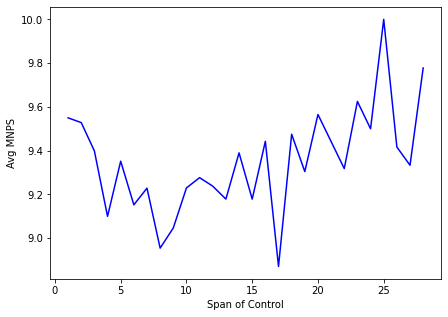

In [664]:
plt.figure(figsize=(7,5))
grp1.plot(color = 'blue')
plt.xlabel('Span of Control')
plt.ylabel ('Avg MNPS') 
plt.show()

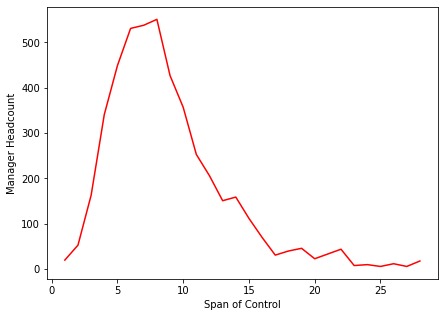

In [643]:
plt.figure(figsize=(7,5))
grp2.plot(color = 'red')
plt.xlabel('Span of Control')
plt.ylabel('Manager Headcount')
plt.show()

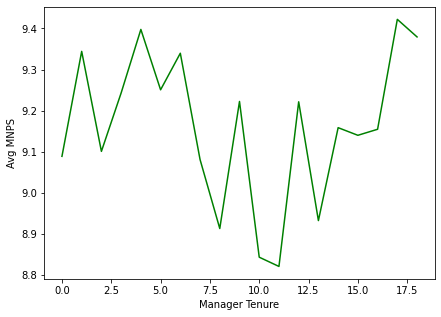

In [645]:
plt.figure(figsize=(7,5))
grp3.plot(color = 'green')
plt.ylabel ('Avg MNPS') 
plt.show()

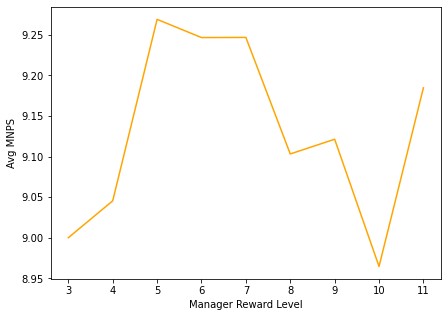

In [646]:
plt.figure(figsize=(7,5))
grp4.plot(color = 'orange')
plt.ylabel('Avg MNPS')
plt.show()

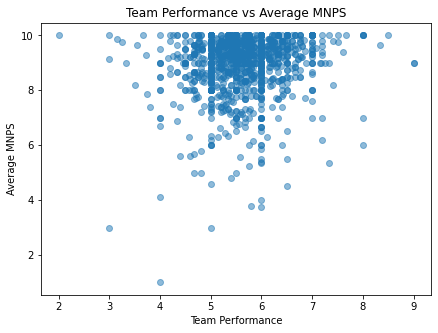

In [620]:
plt.figure(figsize=(7,5))

plt.scatter(data['Team Performance'], data['avg_score'], alpha=0.5)
plt.title("Team Performance vs Average MNPS")
plt.xlabel("Team Performance")
plt.ylabel("Average MNPS")
plt.show()

## Model Building

In [606]:
data.head(5)

,Manager Tenure,Manager SoC,ManagerPM,Manager Type,Manager Reward Level,Team Performance,avg_score
0,18,3,7,2,6,6.333333,10.000000
1,15,5,7,2,9,6.000000,9.250000
2,5,4,5,1,9,6.000000,3.750000
3,5,11,6,2,9,5.555556,6.777778
4,18,10,8,1,5,5.333333,9.888889


In [607]:
Y = data['avg_score']
X = data.drop(['avg_score'], axis = 1)

In [608]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 1234)

In [609]:
print('Training Data Count:{}'.format(X_train.shape[0]))
print('Testing Data Count:{}'.format(X_test.shape[0]))

Training Data Count:866
Testing Data Count:372


In [610]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
pd.options.display.float_format = '{:.5f}'.format
import warnings
import math
import scipy.stats as stats
import scipy
from sklearn.preprocessing import scale
warnings.filterwarnings('ignore')


In [612]:
X_train = sm.add_constant(X_train)


In [614]:
results = sm.OLS(y_train, X_train.astype(float)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_score   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.854
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           6.90e-05
Time:                        12:00:27   Log-Likelihood:                -1269.9
No. Observations:                 866   AIC:                             2554.
Df Residuals:                     859   BIC:                             2587.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.9469      0.344     23.079      0.000       7.271       8.623
Manager Tenure           0.0045      0.007      0.660      0.509      -0.009       0.018
Manager SoC             -0.0167      0.010     -1.741      0.082      -0.035       0.002
ManagerPM                0.1166      0.032      3.693      0.000       0.055       0.179
Manager Type            -0.0856      0.095     -0.897      0.370      -0.273       0.102
Manager Reward Level    -0.0253      0.031     -0.816      0.415      -0.086       0.035
Team Performance         0.1270      0.050      2.561      0.011       0.030       0.224
==============================================================================
Omnibus:                      393.674   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2150.099
Skew:                          -2.041   Prob(JB):                         0.00
Kurtosis:                       9.552   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [622]:
X2 = data[["ManagerPM","Team Performance"]]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,Y,test_size = 0.3, random_state = 1234)

print('Training Data Count:', X2_train.shape[0])
print('Testing Data Count:', X2_test.shape[0])


Training Data Count: 866
Testing Data Count: 372


In [623]:
X2_train = sm.add_constant(X2_train)
result2 = sm.OLS(y2_train, X2_train.astype(float)).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_score   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     11.63
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.04e-05
Time:                        12:18:18   Log-Likelihood:                -1272.8
No. Observations:                 866   AIC:                             2552.
Df Residuals:                     863   BIC:                             2566.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.6351      0.300     25.412      0.000       7.045       8.225
ManagerPM            0.1124      0.031      3.612      0.000       0.051       0.173
Team Performance     0.1198      0.048      2.472      0.014       0.025       0.215
==============================================================================
Omnibus:                      398.280   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2270.301
Skew:                          -2.051   Prob(JB):                         0.00
Kurtosis:                       9.789   Cond. No.                         70.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

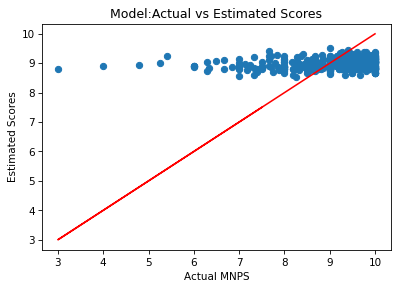

In [626]:

X2_test = sm.add_constant(X2_test)
y2_preds = result2.predict(X2_test)

plt.figure(dpi = 75)
plt.scatter(y2_test,y2_preds)
plt.plot(y2_test, y2_test, color = 'red')
plt.xlabel("Actual MNPS")
plt.ylabel("Estimated Scores")
plt.title("Model:Actual vs Estimated Scores")
plt.show()

In [710]:
print("Mean Absolute Error (MAE)         : {}".format(mean_absolute_error(y2_test, y2_preds)))
print("Mean Squared Error (MSE) : {}".format(mse(y2_test, y2_preds)))
print("Root Mean Squared Error (RMSE) : {}".format(rmse(y2_test, y2_preds)))
print("Root Mean Squared Error (RMSE) : {}".format(rmse(y2_test, y2_preds)))
print("Mean Absolute Perc. Error (MAPE) : {}".format(np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100))

Mean Absolute Error (MAE)         : 0.7371267832690099
Mean Squared Error (MSE) : 1.0395152654635857
Root Mean Squared Error (RMSE) : 1.0195662143596098
Root Mean Squared Error (RMSE) : 1.0195662143596098
Mean Absolute Perc. Error (MAPE) : 9.482924276856316


## Text Pre-processing

In [627]:
# remove rows with length < 5
survey["text1_length"] = survey["What does your manager excel at with regard to supporting your development?"].astype(str).apply(lambda x: len(x))
survey = survey[(survey["text1_length"]>5)]

In [628]:
survey["text1_length"].mean()

132.47805405405404

In [629]:
# remove text1 == NA
survey = survey[(survey["MNPS"] != '(--)')]

In [631]:
# recode categorical variables# recode categorical variables
def my_recode(var):
    if var == 'Disagree':
        return 1
    if var == 'Somewhat Agree':
        return 2
    if var == 'Mostly Agree':
        return 3
    if var == 'Completely Agree':
        return 4
    else:
        return 0

In [632]:
survey["My manager and I have meaningful discussions about my career aspirations."] = survey["My manager and I have meaningful discussions about my career aspirations."].apply(my_recode)
survey["My manager helps me identify and prioritize my development needs for current and future roles."] = survey["My manager helps me identify and prioritize my development needs for current and future roles."].apply(my_recode)
survey["My manager takes actions to support my development."] = survey["My manager takes actions to support my development."].apply(my_recode)
survey["My manager and I discuss progress on my development goals throughout the year."] = survey["My manager and I discuss progress on my development goals throughout the year."].apply(my_recode)
survey["I believe my manager’s actions have helped prepare me for future opportunities and challenges."] = survey["I believe my manager’s actions have helped prepare me for future opportunities and challenges."].apply(my_recode)
survey["I believe my manager and I have a trusting relationship."] = survey["I believe my manager and I have a trusting relationship."].apply(my_recode)
survey["I believe my manager consistently follows through on commitments."] = survey["I believe my manager consistently follows through on commitments."].apply(my_recode)

In [633]:
# get the subset of all-complete-agree rows
high_agree = survey[(survey['My manager and I have meaningful discussions about my career aspirations.'] == 4) &
(survey['My manager helps me identify and prioritize my development needs for current and future roles.'] == 4) & 
(survey['My manager takes actions to support my development.'] == 4) &
(survey['My manager and I discuss progress on my development goals throughout the year.'] == 4) &
(survey['I believe my manager’s actions have helped prepare me for future opportunities and challenges.'] ==4) &
(survey["I believe my manager and I have a trusting relationship."]==4) &
(survey["I believe my manager consistently follows through on commitments."] == 4)]

In [634]:
high_agree.shape

(2085, 31)

In [635]:
disagree = survey[(survey['My manager and I have meaningful discussions about my career aspirations.'] == 1)|
                       (survey['My manager and I have meaningful discussions about my career aspirations.'] == 2) &
(survey['My manager helps me identify and prioritize my development needs for current and future roles.'] == 1 )|
 (survey['My manager helps me identify and prioritize my development needs for current and future roles.'] == 2) & 
(survey['My manager takes actions to support my development.'] == 1 )|
(survey['My manager takes actions to support my development.'] == 2) &
(survey['My manager and I discuss progress on my development goals throughout the year.'] == 1) |
(survey['My manager and I discuss progress on my development goals throughout the year.'] == 2) &
(survey['I believe my manager’s actions have helped prepare me for future opportunities and challenges.'] ==1) |
(survey['I believe my manager’s actions have helped prepare me for future opportunities and challenges.'] ==2) &
(survey["I believe my manager and I have a trusting relationship."]==1)|
(survey["I believe my manager and I have a trusting relationship."]==2) &
(survey["I believe my manager consistently follows through on commitments."] == 1)|
(survey["I believe my manager consistently follows through on commitments."] == 2)]

In [636]:
disagree.shape

(353, 31)

### Trust & No-trust groups comparison

In [17]:
no_trust = survey[(survey['I believe my manager and I have a trusting relationship.'] == 1) & 
              (survey["I believe my manager consistently follows through on commitments."]== 1)]

In [18]:
trust = survey[(survey['I believe my manager and I have a trusting relationship.'] == 4) & 
              (survey['I believe my manager consistently follows through on commitments.']== 4)]

In [19]:
corpus_no_trust =no_trust["What does your manager excel at with regard to supporting your development?"].astype(str)
corpus_trust =trust["What does your manager excel at with regard to supporting your development?"].astype(str)

In [20]:
corpus_no_trust.to_csv('text question1-no trust.csv')
corpus_trust.to_csv('text question1-trust.csv')

### Develop & no-develop groups comparison

In [21]:
develop = survey[(survey['My manager and I have meaningful discussions about my career aspirations.'] == 4) &
(survey['My manager helps me identify and prioritize my development needs for current and future roles.'] == 4) & 
(survey['My manager takes actions to support my development.'] == 4) &
(survey['My manager and I discuss progress on my development goals throughout the year.'] == 4) &
(survey['I believe my manager’s actions have helped prepare me for future opportunities and challenges.'] ==4)]

In [22]:
len(develop)

2194

In [23]:
no_develop = survey[(survey['My manager and I have meaningful discussions about my career aspirations.'] == 1)|
                       (survey['My manager and I have meaningful discussions about my career aspirations.'] == 2) &
(survey['My manager helps me identify and prioritize my development needs for current and future roles.'] == 1 )|
 (survey['My manager helps me identify and prioritize my development needs for current and future roles.'] == 2) & 
(survey['My manager takes actions to support my development.'] == 1 )|
(survey['My manager takes actions to support my development.'] == 2) &
(survey['My manager and I discuss progress on my development goals throughout the year.'] == 1) |
(survey['My manager and I discuss progress on my development goals throughout the year.'] == 2) &
(survey['I believe my manager’s actions have helped prepare me for future opportunities and challenges.'] ==1) |
(survey['I believe my manager’s actions have helped prepare me for future opportunities and challenges.'] ==2)]

In [24]:
len(no_develop)

632

In [25]:
corpus1 = survey["What does your manager excel at with regard to supporting your development?"].astype(str)
corpus1a = high_agree['What does your manager excel at with regard to supporting your development?'].astype(str)

corpus1c = develop['What does your manager excel at with regard to supporting your development?'].astype(str)
corpus1d = no_develop['What could your manager do differently to better support your development?'].astype(str)

corpus1b = disagree['What could your manager do differently to better support your development?'].astype(str)

corpus2 = survey["What could your manager do differently to better support your development?"].astype(str)
corpus3 = survey['What would you tell your manager to do differently so that you are more likely to recommend them as a manager? - Detractor'].astype(str)
corpus4 = survey['What would you tell your manager to do differently so that you are more likely to recommend them as a manager? - Passive'].astype(str)
corpus34 = pd.concat([corpus3, corpus4], keys= ['Detractor','Passive'])
#corpus5 = survey['What behaviors does your manager demonstrate that inspire you to recommend them to your colleagues?-Promotor'].astype(str)

In [26]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#survey.head(10)

In [27]:
print(high_agree['MNPS'].mean())
print(disagree['MNPS'].mean())

9.860431654676258
5.973118279569892


In [29]:
len(corpus2)

4645

### span of control 10,11 vs. 25

In [672]:
soc10_11 = survey[(survey['Manager SoC'] == 10)|(survey['Manager SoC'] == 11)]
soc10_11.shape
soc25 = survey[(survey['Manager SoC']==25)]
soc25.shape

(6, 32)

In [673]:
corpus5 = soc10_11["What could your manager do differently to better support your development?"].astype(str)
corpus6 = soc25["What does your manager excel at with regard to supporting your development?"].astype(str)

## Text preprocessing

In [674]:
NLTK_stop_words_list=stopwords.words('english')
print(NLTK_stop_words_list)
print("Total numbers of stop words are ")
print(len(NLTK_stop_words_list))

custom_stop_word_list = ['zurich','zna','would','america','north',
                         'thing','company','exciting','could',
                         'work','manager', 'also','support', 'supports'
                         'name','executive', 'nothing', 'cannot',
                        'done','anything', 'things','think', 'time',
                        'takes','take','everything', 'makes','make','make', 
                         'regard', 'really','comes','others','great',
                        'good', 'employees','appreciate','moment','point',
                        '(--)','her','his','my','their','that','this',
                        'making','sure','development','day','supportive','need',
                        'let','lets','supporting']
final_stopword_list = custom_stop_word_list + NLTK_stop_words_list

print(len(final_stopword_list))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Check Surrounding Words & Context

### Most Common Bi-grams 

In [695]:

docs =[doc for doc in corpus6]
docs = (' '.join(filter(None, docs))).lower()

tokens = word_tokenize(docs)
tokens = [t for t in tokens if t not in final_stopword_list]
word_l = WordNetLemmatizer()
tokens = [word_l.lemmatize(t) for t in tokens if t.isalpha()]
word_s = PorterStemmer()
tokens = [word_s.stem(t) for t in tokens if t.isalpha()]

bi_grams = list(ngrams(tokens, 1)) 
counter = Counter(bi_grams)
common_bigrams = counter.most_common(10)
common_bigrams

[(('help',), 2),
 (('encourag',), 2),
 (('commun',), 1),
 (('find',), 1),
 (('proper',), 1),
 (('tool',), 1),
 (('role',), 1),
 (('independ',), 1),
 (('posit',), 1),
 (('environ',), 1)]

In [701]:
corpus6

252                                                                         Communication
805     He is very supportive in helping find the proper tools for me to grow.in my role.
1534                                   Encouraging independence in a positive environment
1865                                                                          Good Skills
2391                                                       Very knowledgeable and helpful
5238                                                       He encourages doing new things
Name: What does your manager excel at with regard to supporting your development?, dtype: object

In [218]:
#del common_bigrams[0]
#del common_bigrams[5] # some phrases had high frequency but less information so we can delete some terms


In [696]:
pairs = []
for pair in common_bigrams:
    pairs.append(pair[0])
print(pairs)

[('help',), ('encourag',), ('commun',), ('find',), ('proper',), ('tool',), ('role',), ('independ',), ('posit',), ('environ',)]


In [697]:
#" ".join(pairs[0])

In [698]:
for i in range(0,len(pairs)):
    pairs[i] = " ".join(pairs[i])

In [699]:
pairs_freq = nltk.FreqDist(pairs)

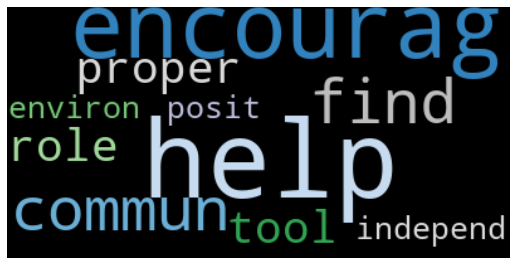

In [700]:
bigram_wordcloud = WordCloud(random_state = 21, colormap="tab20c").generate_from_frequencies(pairs_freq)
plt.figure(figsize = (9,8))
plt.imshow(bigram_wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

### String endwith

In [32]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2), stop_words = final_stopword_list)
X2 = vectorizer2.fit_transform(corpus1)
tri_grams = vectorizer2.get_feature_names()

In [33]:
# Checking surrounding words end with the string
newlist = []
for t in tri_grams:
    if t.endswith('trust'):
        newlist.append(t)
        
print(newlist)

['ability trust', 'attitude trust', 'back trust', 'believe trust', 'blocks trust', 'box trust', 'build trust', 'building trust', 'builds trust', 'completely trust', 'cultivates trust', 'discussing trust', 'displaying trust', 'employee trust', 'environment trust', 'experience trust', 'feedback trust', 'feel trust', 'freedom trust', 'growth trust', 'honesty trust', 'including trust', 'involved trust', 'level trust', 'like trust', 'longer trust', 'mutual trust', 'resources trust', 'says trust', 'sense trust', 'someone trust', 'talk trust', 'tasks trust', 'though trust', 'ways trust']


In [34]:
# start with certain word
r = re.compile("role")
newlist = list(filter(r.match, tri_grams)) 
print(newlist)

['role 2021', 'role 21', 'role accomplish', 'role accomplished', 'role actively', 'role adjuster', 'role advance', 'role allowed', 'role always', 'role appropriate', 'role approves', 'role areas', 'role ask', 'role asks', 'role aspirations', 'role aspiring', 'role become', 'role becomes', 'role better', 'role beyond', 'role brian', 'role career', 'role challenges', 'role change', 'role changes', 'role choose', 'role claims', 'role coordinated', 'role created', 'role current', 'role demonstrate', 'role department', 'role depth', 'role difficult', 'role discuss', 'role discussed', 'role discussion', 'role discussions', 'role dont', 'role due', 'role easy', 'role encourages', 'role ensures', 'role ensuring', 'role entails', 'role etc', 'role even', 'role evolve', 'role example', 'role excels', 'role expected', 'role extremely', 'role fantastic', 'role far', 'role feel', 'role find', 'role first', 'role fostering', 'role future', 'role get', 'role getting', 'role goals', 'role group', 'rol

### Search the original document containing the word

In [681]:
pd.set_option('display.max_colwidth', None)
filter_values =  corpus5[corpus5.str.contains('improve')==True]
print(filter_values)
print(len(filter_values))

3                                                                                                                                                                                                                                                                                                                                                 Provide more feedback on the things I'm doing well and what needs improvement.
1087                                                                                                                                                                                                                                                                                   I would consider my managers actions to be about as good as might possibly be done. There is not many methods to improve neqr-perfection.
1707                                                                                                                                                     As indicated 

In [683]:
pd.set_option('display.max_colwidth', None)
filter_values =  corpus5[corpus5.str.contains('more')==True]
print(filter_values)
print(len(filter_values))

3                                                                                                                                                                                                                                                                                                                         Provide more feedback on the things I'm doing well and what needs improvement.
70                                                                                                                                                                                                                                                                                               Help identify more training opportunities that would help develop my knowledge of my role even further.
318                                                                                                                                                                                                                   

In [71]:
pd.set_option('display.max_colwidth', None)
filter_values =  corpus1[corpus1.str.contains('trusting')==True]
print(filter_values)
print(len(filter_values))

2447                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Empowering and trusting me to do my job and execute.
2672                                                                                                                                                                                         Katelyn always seems to be able to find things that might be something I would have an interest in. She takes the ti

## Classification model

In [38]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

In [39]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [40]:


t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words=final_stopword_list, alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words=final_stopword_list,
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words=final_stopword_list,
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(corpus1)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()



done in 0.082361s
n_samples: 4645, n_features: 2407



In [43]:
if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_size=1000, n_clusters=6, n_init=1,
                verbose=False)
done in 0.097s

Silhouette Coefficient: 0.009



In [44]:
true_k = 6

In [45]:
if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: career aspirations feedback goals discussions open providing understands direction future
Cluster 1: always available questions open discuss discussions one willing answer help
Cluster 2: help job us team always know well willing get opportunities
Cluster 3: new supports opportunities ideas role projects learn team opportunity learning
Cluster 4: opportunities provides goals feedback providing areas growth develop skills future
Cluster 5: communication open listens listening encourages future helps role training understanding


In [46]:
labels = km.predict(X)
freq =Counter(labels)
freq

Counter({5: 2053, 0: 410, 4: 826, 1: 481, 2: 553, 3: 322})

In [47]:
survey['Cluster Label1'] = km.predict(X)


In [48]:
survey.to_csv('survey with label.csv')

In [49]:

t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words=final_stopword_list, alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words=final_stopword_list,
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words=final_stopword_list,
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(corpus3)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()



done in 0.030137s
n_samples: 4645, n_features: 619



In [50]:
if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_size=1000, n_clusters=6, n_init=1,
                verbose=False)
done in 0.078s



In [51]:
if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: team people like us listen feel better comment help know
Cluster 1: nan yes fear field fewer felt feels feeling feel feedback
Cluster 2: team receiving consistently across member information manage hard approach different
Cluster 3: yes feedback find field fewer felt feels feeling feel fear
Cluster 4: yes feedback find field fewer felt feels feeling feel fear
Cluster 5: yes feedback find field fewer felt feels feeling feel fear


In [52]:
labels = km.predict(X)
freq =Counter(labels)
freq

Counter({3: 4440, 0: 203, 1: 2})